# ANLP 2015 Text Classification Assignment

Emily Scharff and Juan Shishido

## Write Up

### Introduction

This notebook contains the code and documentation that we used to obtain our score of **0.58541** on the public leaderboard for the ANLP 2015 Classification Assignment. We describe our text processing, feature engineering, and model selection approaches.

### Text Processing

The data were loaded into pandas DataFrames. We began plotting the frequency of each category in the training set and noticed that the distribution was not uniform. Category 1, for example, was the most well represented with 769 questions. Category 6, on the other hand, had the least amount of questions&mdash;232. This would prove to be a good insight and we'll describe how we used this to our advantage.

In terms of processing the data, our approach was *not* to modify the original text. Rather, we created a new column, `text_clean`, that reflected our changes.

While examining the plain-text training data, we noticed sequences of HTML escaped characters, such as `&#xd;&lt;br&gt;`, which we removed with a regular expression. We also remove non-alphanumeric characters and replace whitespace with single spaces.

### Features and Models

In terms of features, we started simple, using a term-document matrix that only included word frequencies. We also decided to get familiar with a handful of algorithms. We used our word features to train logistic regression and multinomial naive Bayes models. Using Scikit-Learn's `cross_validation` function, we were surprised to find initial scores of around 50% accuracy.

From here, we deviated somewhat and tried document similarity. Using the training data, we combined questions, by category. Our thought was to create seven "documents," one for each category, that represented the words used for the corresponding questions. This resulted in a $7 \times w$ matrix, where $w$ represents the number of unique words *across* documents. This was created using Scikit-Learn's `TfidfVectorizer`. For the test data, the matrix was of dimension $w \times q$, where $q$ represents the number of questions. Note that $w$ is the same in each of our matrices. This is so that it's possible to perform matrix multiplication. Of course, the `cosine_similarity` function, the metric we decided to use, takes care of some of the implementation details. Our first submission was based on this approach. We then stemmed the words in our corpus, using the Porter Stemmer, and that increased our score slightly.

Before proceeding, we decided to use Scikit-Learn's `train_test_split` function to create a development set&mdash;20% of the training data&mdash;on which to test our models. To fit our models, we used the remaining 80% of the original training data.

In our next iteration, we went back to experimenting with logistic regression and naive Bayes, but also added a linear support vector classifier. Here, we also started to add features. Because we were fitting a model, we did *not* combine questions by category. Rather, our tfidf feature matrix had a row for each question.

We tried many features. We ended up with the following list:

* number of question marks
* number of periods
* number of apostrophes
* number of "the"s
* number of words
* number of stop words
* number of first person words
* number of second person words
* number of third person words
* indicators for whether the *first* word was in `['what', 'how', 'why', 'is']`

#### Other features we tried

Unigrams: This feature was used to check for the occurrence of certain unigrams, just as in John's Scikit-Learn notebook. We used it to check for the most frequent words in each category. Using the 500 most frequent words in each category performed the best. However, this performance was outstripped by a simple tfidf and, when combined, only lowered the score.

Numeric: The goal of this feature was to check if a certain question used numbers. The idea was that crtain categories, such as math, would use number more frequently than others, such as entertainment. In practice it did not work out that well.

Similarity: Here we used WordNet's similarity to see how similar the words in the question were to the question's category. This performed quite poorly. We believe this was due to the fact that the similarity function is not that accurate.

POS: We added a feature to count the number of a particular part of speech. We tested it with nouns, verbs, and adjectives. Interestingly the verbs performed the best. However in combination with the other features we chose it seemed to hurt the performance

Median length: Without tfidf, including the length of the median word of a question greatly increased the categorization accuracy. However, after using tfidf, the median length only detracted from the score. Because tfidf performed better, we did not include it in the final set of features.

Names: This feature checked if a particular question contained a name. This worked better than counting the number of names. This is likely due to a lack of data. Overall, the number of questions with names in the training set is small so you can get better classification by only making the feature return

#### Other processing

We also stemmed the words prior to passing them through the `TfidfVectorizer`.

When we noticed some misspelled words, we tried using Peter Norvig's `correct` function, but it did not improve our accuracy scores.

One thing that was helpful was the plots we created when assessing the various models. We plotted the predicted labels against the ground truth. (An example of this in included below.) This helped us see, right away, that the linear SVC was performing best across all the permutations of features we tried. This is how we eventually decided to stick with that algorithm.

During one of the iterations, we noticed that the naive Bayes model was incorrectly predicting category 1 for a majority of the data. We remembered the distribution of categories mentioned earlier and decided to sample the *other* categories at higher frequencies. We took the original training data, and then drew a random sample of questions from categories 2 through 7. After some experimentation, we decided to sample an extra 1,200 observations. This strategy helped improve our score.

We also spend time examining and analyzing the confidence scores using the `decision_function()` method. The idea here was to see if we could identify patterns in *how* the classifier was incorrectly labeling the development set. Unfortunately, we were not able to use this information to improve our scores.

Finally, because of all the testing we had done, we had several results files, which included results we did not submit. With this data, we used a bagging approach&mdash;majority vote&mdash;to get a "final" classification on the 1,874 test examples. This, unfortunately, did not improve our score.

Our best result on the public leaderboard was from a single linear support vector classifier using tfidf and the features listed above.

## Code

### Imports

In [1]:
%matplotlib inline

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [2]:
plt.style.use('ggplot')

### Functions

In [3]:
def sample(df, n=1000, include_cats=[2, 3, 4, 5, 6, 7], random_state=1868):
    """Take a random sample of size `n` for categories
    in `include_cats`.
    """
    df = df.copy()
    subset = df[df.Category.isin(include_cats)]
    sample = subset.sample(n, random_state=random_state)
    return sample

def clean_text(df, col):
    """A function for keeping only alpha-numeric
    characters and replacing all white space with
    a single space.
    """
    df = df.copy()
    porter_stemmer = PorterStemmer()
    return df[col].apply(lambda x: re.sub(';br&', ';&', x))\
                  .apply(lambda x: re.sub('&.+?;', '', x))\
                  .apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                  .apply(lambda x: re.sub('\s+', ' ', x).strip())\
                  .apply(lambda x: ' '.join([porter_stemmer.stem(w)
                                             for w in x.split()]))

def count_pattern(df, col, pattern):
    """Count the occurrences of `pattern`
    in df[col].
    """
    df = df.copy()
    return df[col].str.count(pattern)

def split_on_sentence(text):
    """Tokenize the text on sentences.
    Returns a list of strings (sentences).
    """
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    return sent_tokenizer.tokenize(text)

def split_on_word(text):
    """Use regular expression tokenizer.
    Keep apostrophes.
    Returns a list of lists, one list for each sentence:
        [[word, word], [word, word, ..., word], ...].
    """
    if type(text) is list:
        return [regexp_tokenize(sentence, pattern="\w+(?:[-']\w+)*")
                for sentence in text]
    else:
        return regexp_tokenize(text, pattern="\w+(?:[-']\w+)*")

def features(df):
    """Create the features in the specified DataFrame."""
    stop_words = stopwords.words('english')
    df = df.copy()
    df['n_questionmarks'] = count_pattern(df, 'Text', '\?')
    df['n_periods'] = count_pattern(df, 'Text', '\.')
    df['n_apostrophes'] = count_pattern(df, 'Text', '\'')
    df['n_the'] = count_pattern(df, 'Text', 'the ')
    
    df['first_word'] = df.text_clean.apply(lambda x: split_on_word(x)[0])
    question_words = ['what', 'how', 'why', 'is']
    for w in question_words:
        col_wc = 'n_' + w
        col_fw = 'fw_' + w
        df[col_fw] = (df.first_word == w) * 1
        
    del df['first_word']
    
    df['n_words'] = df.text_clean.apply(lambda x: len(split_on_word(x)))
    df['n_stopwords'] = df.text_clean.apply(lambda x:
                                            len([w for w in split_on_word(x)
                                                 if w not in stop_words]))
    
    df['n_first_person'] = df.text_clean.apply(lambda x:
                                               sum([w in person_first
                                                    for w in x.split()]))
    df['n_second_person'] = df.text_clean.apply(lambda x:
                                                sum([w in person_second
                                                     for w in x.split()]))
    df['n_third_person'] = df.text_clean.apply(lambda x:
                                               sum([w in person_third
                                                    for w in x.split()]))
    
    return df

def flatten_words(list1d, get_unique=False):
    qa = [s.split() for s in list1d]
    if get_unique:
        return sorted(list(set([w for sent in qa for w in sent])))
    else:
        return [w for sent in qa for w in sent]

def tfidf_matrices(tr, te, col='text_clean'):
    """Returns tfidf matrices for both the
    training and test DataFrames.
    The matrices will have the same number of
    columns, which represent unique words, but
    not the same number of rows, which represent
    samples.
    """
    tr = tr.copy()
    te = te.copy()
    text = tr[col].values.tolist() + te[col].values.tolist()
    vocab = flatten_words(text, get_unique=True)
    tfidf = TfidfVectorizer(stop_words='english', vocabulary=vocab)
    tr_matrix = tfidf.fit_transform(tr.text_clean)
    te_matrix = tfidf.fit_transform(te.text_clean)
    return tr_matrix, te_matrix

def concat_tfidf(df, matrix):
    df = df.copy()
    df = pd.concat([df, pd.DataFrame(matrix.todense())], axis=1)
    return df

def jitter(values, sd=0.25):
    """Jitter points for use in a scatterplot."""
    return [np.random.normal(v, sd) for v in values]

In [4]:
person_first = ['i', 'we', 'me', 'us', 'my', 'mine', 'our', 'ours']
person_second = ['you', 'your', 'yours']
person_third = ['he', 'she', 'it', 'him', 'her', 'his', 'hers', 'its']

### Data

#### Load

In [5]:
training = pd.read_csv('../data/newtrain.csv')
test = pd.read_csv('../data/newtest.csv')

#### Clean

In [6]:
training['text_clean'] = clean_text(training, 'Text')
test['text_clean'] = clean_text(test, 'Text')

#### Features

In [7]:
training = features(training)
test = features(test)

#### Split the training data

In [8]:
train, dev = cross_validation.train_test_split(training, test_size=0.2, random_state=1868)

In [9]:
train = train.append(sample(train, n=800))

In [10]:
train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)

#### tfidf

In [11]:
train_matrix, dev_matrix = tfidf_matrices(train, dev)

#### Combine

In [12]:
train = concat_tfidf(train, train_matrix)
dev = concat_tfidf(dev, dev_matrix)

### Training

In [13]:
svm = LinearSVC(dual=False, max_iter=5000)

In [14]:
features = train.columns[3:]
X = train[features].values
y = train['Category'].values
features_dev = dev[features].values

### Testing on `dev`

In [15]:
svm.fit(X, y)
dev_predicted = svm.predict(features_dev)

In [16]:
accuracy_score(dev.Category, dev_predicted)

0.57407407407407407

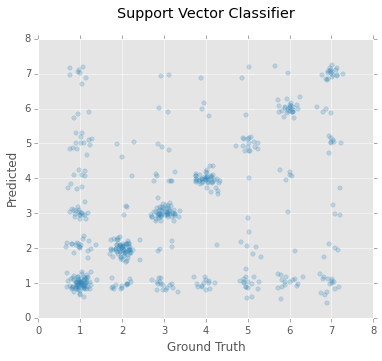

In [17]:
plt.figure(figsize=(6, 5))

plt.scatter(jitter(dev.Category, 0.15),
            jitter(dev_predicted, 0.15),
            color='#348ABD', alpha=0.25)

plt.title('Support Vector Classifier\n')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted')

### Test Data

In [18]:
training = training.append(sample(training, n=1200))
training.reset_index(drop=True, inplace=True)

In [19]:
training_matrix, test_matrix = tfidf_matrices(training, test)

In [20]:
training = concat_tfidf(training, training_matrix)
test = concat_tfidf(test, test_matrix)

In [21]:
features = training.columns[3:]
X = training[features].values
y = training['Category'].values
features_test = test[features].values

In [22]:
svm.fit(X, y)
test_predicted = svm.predict(features_test)

In [23]:
test['Category'] = test_predicted
output = test[['Id', 'Category']]